In [ ]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
#plt.rcParams['font.family'] = 'Malgun Gothic'
#plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold, cross_val_score

# 평가함수
# 분류용
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from collections import Counter

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 학습 모델 저장을 위한 라이브러리
import pickle

### 프로젝트 셋팅

In [ ]:
# 학습이 완료된 모델을 저장할 파일 이름
best_model_path = 'model/best_model_pitcher_0811_salRank_2ND.dat'

# 교차검증 횟수
cv_count = 10

# 교차 검증
kfold = KFold(n_splits=cv_count, shuffle=True, random_state=1)

# 평가 결과를 담을 리스트
# 필요하다면 다른 것도 만들어주세요
f1_macro_list = []
f1_micro_list = []

# 학습 모델 이름
model_name_list = []

### 데이터 준비

In [ ]:
df_all = pd.read_csv('투수_연봉_학습데이터.csv')

# 예측에 사용될 24년 데이터 제거
df = df_all[df_all['연도'] != 2024].copy()

# 2021~2023 스탯만 (학습: 2021~2022, 검증: 2023)
train_mask = df['연도'] <= 2022
valid_mask = df['연도'] == 2023

In [ ]:
df_all

,선수,포지션,WAR,G,GS,GR,GF,CG,SHO,W,...,연도,선발,중간계투,마무리,수상여부,연봉 총수령액(만원),연봉등급(만원),팀연봉순위,전체연봉순위,연봉등급(순위)
0,임기영,투수,3.17,28,28,0,0,0,0,8,...,2021,1,0,0,0,14000,B,14,173,C
1,이의리,투수,2.76,19,19,0,0,0,0,4,...,2021,1,0,0,0,39000,B,8,85,C
2,정해영,투수,2.69,64,0,64,58,0,0,5,...,2021,0,0,1,0,17000,B,11,157,C
3,장현식,투수,2.56,69,0,69,5,0,0,1,...,2021,0,1,0,0,20000,B,10,134,C
4,윤중현,투수,1.38,30,13,17,6,0,0,5,...,2021,1,0,0,0,6500,C,29,313,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,김도빈,투수,-0.11,1,1,0,0,0,0,0,...,2024,0,1,0,0,3100,D,57,516,D
951,이충호,투수,-0.12,3,0,3,0,0,0,0,...,2024,0,1,0,0,3400,D,49,453,D
952,장지수,투수,-0.14,13,0,13,7,0,0,0,...,2024,0,1,0,0,3400,D,49,453,D
953,윤대경,투수,-0.26,7,0,7,1,0,0,0,...,2024,0,1,0,0,7000,C,28,264,C


In [ ]:
drop_cols = ['pid','선수','포지션','팀','연봉 총수령액(만원)','연봉등급(만원)','연봉등급(순위)',
             '팀연봉순위','전체연봉순위', '계약금(만원)','계약금(만원)분할','연도']
drop_cols = [c for c in drop_cols if c in df.columns]

In [ ]:
# 표준화를 위해 결과데이터를 제외
X_raw = df.drop(columns=drop_cols)

# 표준화
scaler1 = StandardScaler()
scaler1.fit(X_raw[train_mask])

StandardScaler()

In [ ]:
# 연봉 등급 인코딩
encoder = LabelEncoder()

encoder.fit(df.loc[train_mask, '연봉등급(만원)'])
y_encoded = encoder.transform(df['연봉등급(만원)'])

In [ ]:
# 입력과 결과로 나눈다.
X = scaler1.transform(X_raw)
y = y_encoded

In [ ]:
# 6) 학습/검증 분리
train_X = X[train_mask]
train_y = y[train_mask]

X_valid = X[valid_mask]
y_valid = y[valid_mask]

In [ ]:
X_valid = X[valid_mask]
y_valid = y_encoded[valid_mask]

In [ ]:
groups_cv = df.loc[train_mask, 'pid'].values  # 21~22년 학습셋과 동일 범위

### 경계거리 기반 가중치 준비

In [ ]:
# 1) 총보장액(연속값) 만들기 — Series로 두면 마스크 적용이 편함
total_pay = df['연봉 총수령액(만원)'].fillna(0).astype(float)
if '계약금(만원)분할' in df.columns:
    total_pay = total_pay + df['계약금(만원)분할'].fillna(0).astype(float)
if 'FA금(만원)' in df.columns:
    total_pay = total_pay + df['FA금(만원)'].fillna(0).astype(float)

# 2) ***핵심***: train_y와 같은 구간/순서로 맞추기
#    (train_mask는 네가 이미 만들었던 학습 구간 마스크)
y_cont = total_pay[train_mask].to_numpy()      # ← 길이 = len(train_y)

# 3) 컷라인 (bins 사용)
edges = np.array([5000, 10000, 50000], dtype=float)

# 4) 클래스 가중치(역빈도) — 길이 = len(train_y)
K, N = 4, len(train_y)
cnt = Counter(train_y)
w_class = np.array([N/(K*cnt[c]) for c in train_y], dtype=float)

# 5) 경계까지 최소거리(가까울수록 가중 ↑)
dist = np.min(np.abs(y_cont.reshape(-1,1) - edges.reshape(1,-1)), axis=1)
alpha = 2.0
sigma = np.std(y_cont) * 0.05
w_boundary = 1.0 + alpha * np.exp(-dist / sigma)

# 6) C/D 경계 추가 강화(선택) — encoder에서 C,D 인덱스 자동 검출
c_idx = int(np.where(encoder.classes_ == 'C')[0][0])
d_idx = int(np.where(encoder.classes_ == 'D')[0][0])

delta = np.std(y_cont) * 0.01
gamma = 1.8
mask_cd = ((train_y == c_idx) | (train_y == d_idx)) & (np.abs(y_cont - edges[2]) <= delta)
w_boundary[mask_cd] *= gamma

# 7) 최종 학습 가중치
w_train = np.clip(w_class * w_boundary, 1.0, 5.0)

### 기본 모델 사용하기

In [ ]:
# GradientBoost

# (1) KFold → GroupKFold로 교체
kfold = GroupKFold(n_splits=5)

# (2) 같은 선수끼리 한 폴드로 묶기
groups_cv = df.loc[train_mask, 'pid'].values

gb_basic_model = GradientBoostingClassifier(random_state=42)

# 교차 검증을 수행한다
scores = cross_validate(
    gb_basic_model,
    train_X, train_y,
    scoring={'f1_macro':'f1_macro', 'f1_micro':'f1_micro'},
    cv=kfold, groups=groups_cv, n_jobs=-1,
    fit_params={'sample_weight': w_train}  # ← 여기서 폴드별 학습에 가중치 전달
)
f1_macro = scores['test_f1_macro'].mean()
f1_micro = scores['test_f1_micro'].mean()

# 평가 결과를 담아준다.
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("GradientBoost Basic")

In [ ]:
# LGBM
lgbm_basic_model = LGBMClassifier(verbose=-1, random_state=42)

# 교차 검증을 수행한다
scores = cross_validate(
    lgbm_basic_model, train_X, train_y,
    scoring={'f1_macro': 'f1_macro', 'f1_micro': 'f1_micro'},
    cv=kfold, groups=groups_cv, n_jobs=-1,
    fit_params={'sample_weight': w_train}   # ← 경계가중치 포함 가중치
)
f1_macro = scores['test_f1_macro'].mean()
f1_micro = scores['test_f1_micro'].mean()

f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

model_name_list.append("LGBM Basic")


In [ ]:
# XGBoost

xgboost_basic_model = XGBClassifier(
    tree_method='gpu_hist', predictor='gpu_predictor',
    eval_metric='mlogloss', random_state=42
)

# 교차 검증을 수행한다
scores = cross_validate(
    xgboost_basic_model, train_X, train_y,
    scoring={'f1_macro':'f1_macro','f1_micro':'f1_micro'},
    cv=kfold, groups=groups_cv, n_jobs=-1,
    fit_params={'sample_weight': w_train}   # ← 경계가중치 전달
)
f1_macro = scores['test_f1_macro'].mean()
f1_micro = scores['test_f1_micro'].mean()

f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

model_name_list.append("XGBoost Basic")


In [ ]:
# HardVoting 구성
hv = VotingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('lgb', LGBMClassifier(verbose=-1, random_state=42)),
        ('xgb', XGBClassifier(verbosity=0, random_state=42, eval_metric='mlogloss'))
    ],
    voting='hard'
)

scores = cross_validate(
    hv, train_X, train_y,
    scoring={'f1_macro':'f1_macro','f1_micro':'f1_micro'},
    cv=kfold, groups=groups_cv, n_jobs=-1,
    fit_params={'sample_weight': w_train}  # ← 경계가중치 전달
)
f1_macro = scores['test_f1_macro'].mean()
f1_micro = scores['test_f1_micro'].mean()

f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

model_name_list.append("HardVoting Basic")

In [ ]:
# SoftVoting 구성
sv = VotingClassifier(
    estimators=[
        ('gb', GradientBoostingClassifier(random_state=42)),
        ('lgb', LGBMClassifier(verbose=-1, random_state=42)),
        ('xgb', XGBClassifier(verbosity=0, random_state=42, eval_metric='mlogloss'))
    ],
    voting='soft'
)

scores = cross_validate(
    sv, train_X, train_y,
    scoring={'f1_macro':'f1_macro','f1_micro':'f1_micro'},
    cv=kfold, groups=groups_cv, n_jobs=-1,
    fit_params={'sample_weight': w_train}
)
f1_macro = scores['test_f1_macro'].mean()
f1_micro = scores['test_f1_micro'].mean()

f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

model_name_list.append("SoftVoting Basic")

In [ ]:
result_df = pd.DataFrame({
    'Model': model_name_list,
    'F1 Macro': f1_macro_list,
    'F1 Micro': f1_micro_list
})

# 성능 기준 정렬 (선택)
result_df = result_df.sort_values(by='F1 Macro', ascending=False).reset_index(drop=True)

# 출력
display(result_df.round(4))

,Model,F1 Macro,F1 Micro
0,HardVoting Basic,0.6228,0.6384
1,SoftVoting Basic,0.6223,0.6405
2,LGBM Basic,0.6221,0.6405
3,GradientBoost Basic,0.5997,0.6116
4,XGBoost Basic,0.5873,0.6095


### 하이퍼 파라미터 튜닝

In [ ]:
# LGBM
params = {
    'num_leaves': [31, 63],          # 분기 표현력 ↑ (C↔D 경계에 도움)
    'max_depth': [-1, 8],            # -1=제한없음
    'min_child_samples': [20, 60],   # leaf 최소 표본 (과적합 억제)
    'learning_rate': [0.05, 0.1],
    'n_estimators': [300, 600],      # lr 낮추면 트리 수↑
    'subsample': [0.8, 1.0],         # (=bagging_fraction)
    'colsample_bytree': [0.8, 1.0],  # (=feature_fraction)
    'reg_lambda': [0.0, 1.0]         # L2 규제(경계 흔들림 완화)
}

# LGBM 모델 정의
temp_model = LGBMClassifier(
    device_type='cpu',
    random_state=42, n_jobs=-1, verbose=-1,
    class_weight=None
)

# f1_macro 기준으로 하이퍼파라미터 튜닝
lgbm_grid_clf = GridSearchCV(
    temp_model, param_grid=params, scoring='f1_macro',
    cv=kfold, n_jobs=-1
)
lgbm_grid_clf.fit(train_X, train_y, groups=groups_cv, sample_weight=w_train)

# 최적 모델 추출
best_lgbm_model = lgbm_grid_clf.best_estimator_

# f1_macro, f1_micro 평가
scores = cross_validate(
    best_lgbm_model, train_X, train_y,
    scoring={'f1_macro':'f1_macro', 'f1_micro':'f1_micro'},
    cv=kfold, groups=groups_cv, n_jobs=-1,
    fit_params={'sample_weight': w_train}
)
f1_macro = scores['test_f1_macro'].mean()
f1_micro = scores['test_f1_micro'].mean()

# 평가 결과를 담아준다
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("LGBM Tuning")


In [ ]:
# XGBoost
params = {
    'n_estimators': [300, 600],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [0.0, 1.0],
    'gamma': [0, 1]   # min_split_loss
}

# 모델 정의
temp_model = XGBClassifier(
    tree_method='gpu_hist', predictor='gpu_predictor',
    eval_metric='mlogloss', random_state=42
)

# f1_macro 기준으로 튜닝
xgboost_grid_clf = GridSearchCV(
    temp_model, param_grid=params, scoring='f1_macro', cv=kfold, n_jobs=-1
)
xgboost_grid_clf.fit(train_X, train_y, groups=groups_cv, sample_weight=w_train)

# 최적 모델 추출
best_xgb_model = xgboost_grid_clf.best_estimator_

# 성능 평가
scores = cross_validate(
    best_xgb_model, train_X, train_y,
    scoring={'f1_macro':'f1_macro', 'f1_micro':'f1_micro'},
    cv=kfold, groups=groups_cv, n_jobs=-1,
    fit_params={'sample_weight': w_train}
)
f1_macro = scores['test_f1_macro'].mean()
f1_micro = scores['test_f1_micro'].mean()

# 평가 결과를 담아준다
f1_macro_list.append(f1_macro)
f1_micro_list.append(f1_micro)

# 학습 모델 이름을 담아준다.
model_name_list.append("XGBoost Tuning")

In [ ]:
result_df = pd.DataFrame({
    'Model': model_name_list,
    'F1 Macro': f1_macro_list,
    'F1 Micro': f1_micro_list
})

# 성능 기준 정렬 (선택)
result_df = result_df.sort_values(by='F1 Macro', ascending=False).reset_index(drop=True)

# 출력
display(result_df.round(4))

,Model,F1 Macro,F1 Micro
0,XGBoost Tuning,0.6368,0.6528
1,HardVoting Basic,0.6228,0.6384
2,SoftVoting Basic,0.6223,0.6405
3,LGBM Basic,0.6221,0.6405
4,LGBM Tuning,0.6128,0.6280
5,GradientBoost Basic,0.5997,0.6116
6,XGBoost Basic,0.5873,0.6095


### 혼동 행렬 그리기

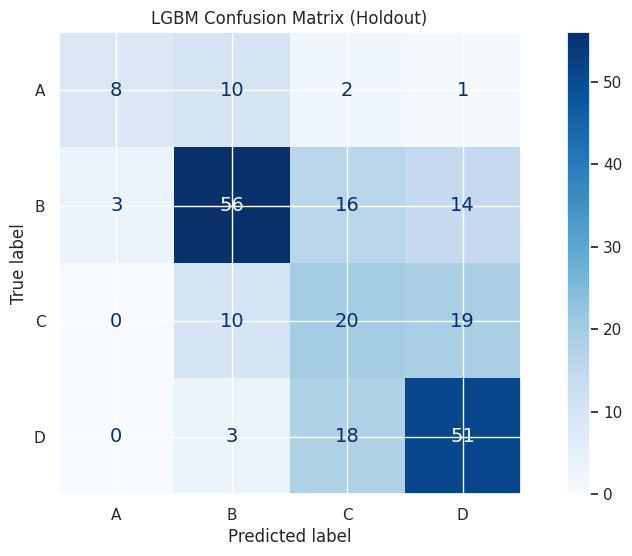

In [ ]:
# LGBM
best_lgbm_model.fit(train_X, train_y)
y_pred = best_lgbm_model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred, labels=np.arange(len(encoder.classes_)))
disp = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues')
plt.title("LGBM Confusion Matrix (Holdout)")
plt.show()

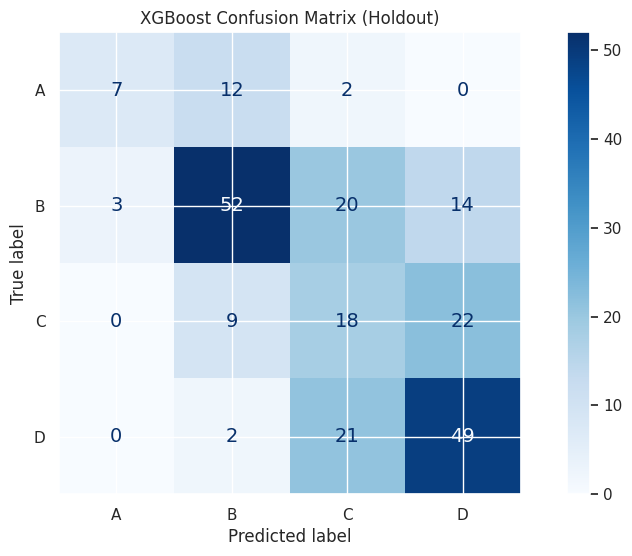

In [ ]:
# XGBoost
best_xgb_model.fit(train_X, train_y)
y_pred = best_xgb_model.predict(X_valid)

cm = confusion_matrix(
    y_valid,
    y_pred,
    labels=np.arange(len(encoder.classes_))
)

disp = ConfusionMatrixDisplay(cm, display_labels=encoder.classes_)
disp.plot(cmap='Blues')
plt.title("XGBoost Confusion Matrix (Holdout)")
plt.show()

In [ ]:
from sklearn.metrics import classification_report, f1_score

def eval_holdout(model, name):
    y_pred = model.predict(X_valid)
    print(name, "MacroF1:", f1_score(y_valid, y_pred, average='macro'),
          "MicroF1:", f1_score(y_valid, y_pred, average='micro'))
    print(classification_report(y_valid, y_pred, target_names=encoder.classes_))

# 가중치로 학습된 '최적' 그대로 쓰기 (다시 fit 하지 않기!)
best_lgbm = lgbm_grid_clf.best_estimator_
best_xgb  = xgboost_grid_clf.best_estimator_

eval_holdout(best_xgb,  "XGB (holdout)")
eval_holdout(best_lgbm, "LGBM (holdout)")


XGB (holdout) MacroF1: 0.5093089484044998 MicroF1: 0.5454545454545454
              precision    recall  f1-score   support

           A       0.70      0.33      0.45        21
           B       0.69      0.58      0.63        89
           C       0.30      0.37      0.33        49
           D       0.58      0.68      0.62        72

    accuracy                           0.55       231
   macro avg       0.57      0.49      0.51       231
weighted avg       0.57      0.55      0.55       231

LGBM (holdout) MacroF1: 0.549325144070367 MicroF1: 0.5844155844155844
              precision    recall  f1-score   support

           A       0.73      0.38      0.50        21
           B       0.71      0.63      0.67        89
           C       0.36      0.41      0.38        49
           D       0.60      0.71      0.65        72

    accuracy                           0.58       231
   macro avg       0.60      0.53      0.55       231
weighted avg       0.60      0.58      0.59  

In [ ]:
# 최적 LGBM (재학습 X, GridSearchCV 결과 그대로)
best_model = lgbm_grid_clf.best_estimator_

feature_cols = list(X_raw.columns)
label_order  = list(getattr(encoder, 'classes_', []))

save_objects = {
    'model': best_model,          # LGBMClassifier 객체
    'encoder': encoder,
    'scaler': scaler1,
    'feature_cols': feature_cols,
    'drop_cols': drop_cols,
    'label_order': label_order,
    'best_params': getattr(lgbm_grid_clf, 'best_params_', None),
    # 'mult': best_m  # (선택) 임계값 배수 튜닝 했으면 같이 저장
}

best_model_path = "fa_grade_lgbm.dat"
import pickle
with open(best_model_path, 'wb') as fp:
    pickle.dump(save_objects, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(best_model_path, 'rb') as fp:
    obj = pickle.load(fp)

model   = obj['model']
encoder = obj['encoder']
feats   = obj['feature_cols']
mult    = obj.get('mult', np.ones(len(encoder.classes_)))  # 임계값 배수 저장 안 됐으면 전부 1

# 2023 홀드아웃으로 평가
X_valid = df.loc[valid_mask, feats]
y_valid = encoder.transform(df.loc[valid_mask, '연봉등급(만원)'])

y_pred = (model.predict_proba(X_valid) * mult).argmax(1)
print("F1 Macro:", f1_score(y_valid, y_pred, average='macro'))

F1 Macro: 0.29034924040988325
